In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim

from torchvision import transforms
from torch.utils.data import DataLoader

from super_resolution.src.sen2venus_dataset import (
    create_train_validation_test_split,
    default_patch_transform,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet

In [3]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

In [4]:
train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", sites={"SO2"}
)
print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 516
Num validation 111
Num test 111


In [5]:
def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]
    x_channel_max = x.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
    x_channel_min = x.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)
    y_channel_max = y.max(dim=1)[0].max(1)[0].unsqueeze(1).unsqueeze(1)
    y_channel_min = y.min(dim=1)[0].min(1)[0].unsqueeze(1).unsqueeze(1)

    x = (x - x_channel_min) / (x_channel_max - x_channel_min)
    y = (y - y_channel_min) / (y_channel_max - y_channel_min)

    return x, y

In [6]:
train_patches.set_transform(image_transform)

In [7]:
train_loader = DataLoader(train_patches, batch_size=2)

In [8]:
for i, (low_res, high_res) in enumerate(train_loader):
    print(
        f"batch {i}\n"
        f"low resolution batch shape {low_res.shape}\n"
        f"high resolution batch shape {high_res.shape}\n"
    )
    break

batch 0
low resolution batch shape torch.Size([2, 3, 128, 128])
high resolution batch shape torch.Size([2, 3, 256, 256])



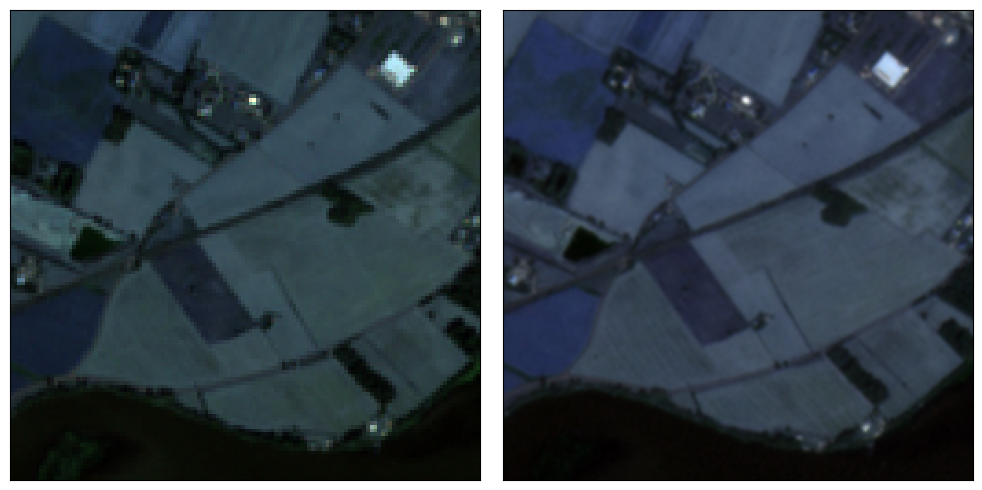

In [9]:
low_res_example = low_res[0]
high_res_example = high_res[0]
plot_gallery(
    [low_res_example.permute(1, 2, 0), high_res_example.permute(1, 2, 0)],
    xscale=5,
    yscale=5,
)

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,  # Always set to true for training
    batch_size=8,  # Always try to set as powers of 2
    drop_last=True,  # Ensures batch size is always the one given (Drops last if its is smaller)
    pin_memory=should_pin_memory[device.type],  # Faster push to GPU
    num_workers=0,  # Load data in parallel but costs more memory
)

In [26]:
device

device(type='cuda')

In [39]:
model = SRResNet(scaling_factor=2)

In [80]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

In [87]:
1 / 0

ZeroDivisionError: division by zero

In [88]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [85]:
model = model.to(device)
model = model.train()

In [73]:
NUM_EPOCHS = 20

In [90]:
# ~21min for 10 epochs

losses = []
epoch_losses = []
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    epoch_loss = 0.0
    for low_res_batch, high_res_batch in progress_bar:
        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        optimizer.zero_grad()

        # Loss and update
        out = model(low_res_batch)
        loss = criterion(out, high_res_batch)
        loss.backward()
        optimizer.step()

        # Collect data
        epoch_loss += loss.item()
        losses.append(loss.item())
        progress_bar.set_postfix(epoch=epoch, batch_loss=loss.item())

    epoch_loss /= len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch: {epoch} / loss: {epoch_loss:.3f}")

100%|██████████████████████████████████| 64/64 [00:20<00:00,  3.17it/s, batch_loss=0.00515, epoch=0]


Epoch: 0 / loss: 0.006


 64%|█████████████████████▊            | 41/64 [00:12<00:07,  3.23it/s, batch_loss=0.00368, epoch=1]

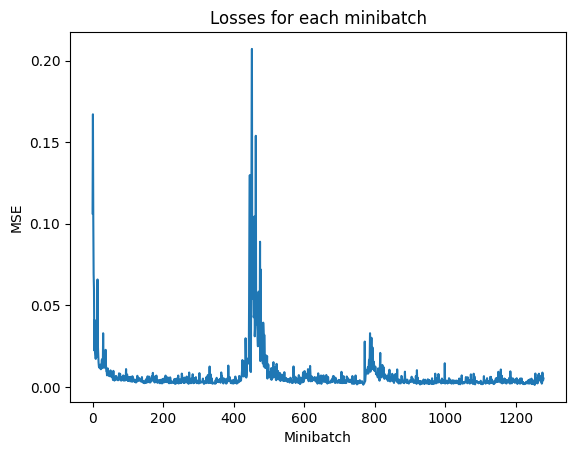

In [44]:
plt.plot(losses)
plt.title("Losses for each minibatch")
plt.xlabel("Minibatch")
plt.ylabel("MSE")
plt.show()

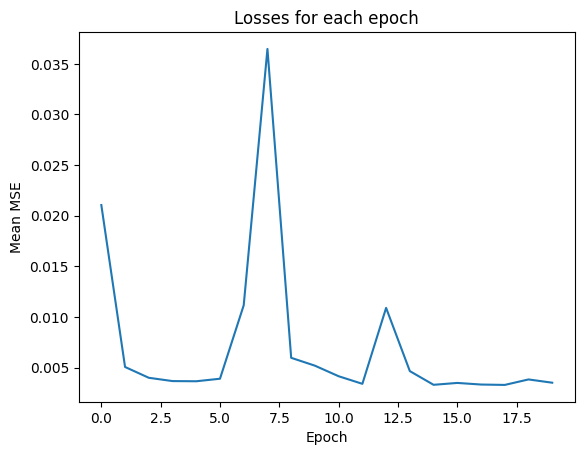

In [45]:
plt.plot(epoch_losses)
plt.title("Losses for each epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean MSE")
plt.show()

In [ ]:
experiment = {
    "epoch_losses": epoch_losses,
    "batch_losses": losses,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}
save_file = RESULTS_DIR / "basic_sr_results.pkl"

In [63]:
train_loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(train_loader.__iter__())

In [64]:
model = model.to("cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


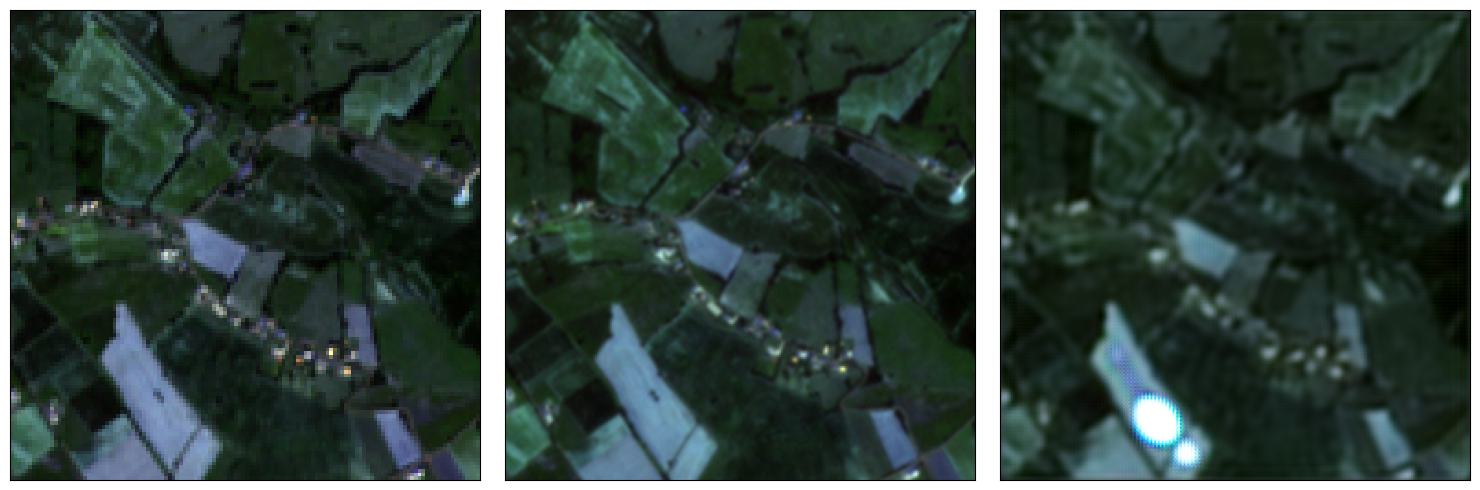

In [65]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = model(low_res_example.unsqueeze(0)).detach()
plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out[0].permute(1, 2, 0),
    ],
    xscale=5,
    yscale=5,
)